# Titanic analysis
### Using the `playbook` conda environment

Build a model then use SHAP to understand the predictions.

https://shap.readthedocs.io/en/latest/index.html

In [1]:
import numpy as np
import shap
import pandas as pd
import os

import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

Read in the _Titanic_ data.

In [2]:
titanic_filename = 'titanic-train.csv'
titanic_path = '~/repos/titanic/data'
titanic_df = pd.read_csv(os.path.join(titanic_path, titanic_filename))

In [3]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df['Cabin_0'] = titanic_df['Cabin'].str.slice(stop=1)

In [5]:
target = 'Survived'
predictors = ['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Cabin_0', 'Embarked', 'SibSp']

In [6]:
cat_features = ['Sex', 'Cabin_0', 'Embarked']
non_cat_features = [predictor for predictor in predictors if predictor not in cat_features]

### Set up the pipelines

In [7]:
ohe_pipeline = Pipeline([
    ('catboost_encoder', ce.CatBoostEncoder(cols=cat_features))
], verbose=False)

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', ohe_pipeline, cat_features),
        ('impute', SimpleImputer(), non_cat_features)
    ],
    remainder='passthrough'
)

In [9]:
ohe_pipeline.fit(titanic_df[predictors], titanic_df[target])

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Pipeline(steps=[('catboost_encoder',
                 CatBoostEncoder(cols=['Sex', 'Cabin_0', 'Embarked']))])

In [10]:
preprocessor.fit(titanic_df[predictors], titanic_df[target])
preprocessor.transform(titanic_df[predictors])

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


array([[ 0.1892454 ,  0.29997651,  0.33702921, ...,  0.        ,
         7.25      ,  1.        ],
       [ 0.74090107,  0.58973064,  0.55256709, ...,  0.        ,
        71.2833    ,  1.        ],
       [ 0.74090107,  0.29997651,  0.33702921, ...,  0.        ,
         7.925     ,  0.        ],
       ...,
       [ 0.74090107,  0.29997651,  0.33702921, ...,  2.        ,
        23.45      ,  1.        ],
       [ 0.1892454 ,  0.58973064,  0.55256709, ...,  0.        ,
        30.        ,  0.        ],
       [ 0.1892454 ,  0.29997651,  0.38953639, ...,  0.        ,
         7.75      ,  0.        ]])

Train a model using `GradientBoostingClassifier`.

In [11]:
pipeline = Pipeline([
    ('features', preprocessor),
    ('gbm', XGBClassifier())
                     ], verbose=True)

For catboost encoding need to randomly permute the rows.

In [12]:
# Random permutation 
perm = np.random.permutation(len(titanic_df)) 
X_res_new = titanic_df[predictors].copy()
X_res_new = X_res_new.iloc[perm].reset_index(drop=True) 
y_res_new = titanic_df[target].copy()
y_res_new = y_res_new.iloc[perm].reset_index(drop=True)

In [13]:
pipeline.fit(X_res_new, y_res_new)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[20:46:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............... (step 2 of 2) Processing gbm, total=   0.1s


Pipeline(steps=[('features',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('catboost_encoder',
                                                                   CatBoostEncoder(cols=['Sex',
                                                                                         'Cabin_0',
                                                                                         'Embarked']))]),
                                                  ['Sex', 'Cabin_0',
                                                   'Embarked']),
                                                 ('impute', SimpleImputer(),
                                                  ['Pclass', 'Age', 'Parch',
                                                   'Fare', 'SibSp'])])),
                ('gbm',
                 XGBClassifier(base_score=0.5, booster='gbtree',
       

In [14]:
pred = pipeline.predict(titanic_df[predictors])

In [15]:
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('features',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('catboost_encoder',
                                                                   CatBoostEncoder(cols=['Sex',
                                                                                         'Cabin_0',
                                                                                         'Embarked']))]),
                                                  ['Sex', 'Cabin_0',
                                                   'Embarked']),
                                                 ('impute', SimpleImputer(),
                                                  ['Pclass', 'Age', 'Parch',
                                                   'Fare', 'SibSp'])])),
                ('gbm',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsampl...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))],
         verbose=True)

## Feature importance

We can get the feature importance directly from the GBM model.

In [16]:
# get the feature names
feature_names = []

In [17]:
feature_names.extend(pipeline['features'].transformers_[0][1].named_steps['catboost_encoder'].get_feature_names())

In [18]:
feature_names.extend(non_cat_features)

In [19]:
print(feature_names[:10])
len(feature_names)

['Sex', 'Cabin_0', 'Embarked', 'Pclass', 'Age', 'Parch', 'Fare', 'SibSp']


8

<AxesSubplot:>

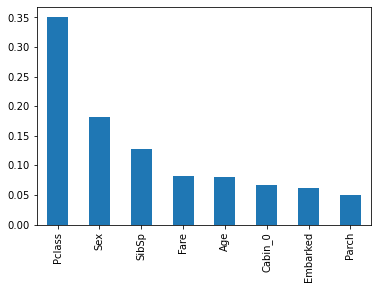

In [20]:
%matplotlib inline
feature_imp = pd.Series(pipeline['gbm'].feature_importances_, index=feature_names).sort_values(ascending=False)
feature_imp.plot.bar()

In [21]:
shap.initjs()

Pipelines are not directly supported by `SHAP`.

In [22]:
featurizer = pipeline['features']

In [23]:
featurizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 Pipeline(steps=[('catboost_encoder',
                                                  CatBoostEncoder(cols=['Sex',
                                                                        'Cabin_0',
                                                                        'Embarked']))]),
                                 ['Sex', 'Cabin_0', 'Embarked']),
                                ('impute', SimpleImputer(),
                                 ['Pclass', 'Age', 'Parch', 'Fare', 'SibSp'])])

In [24]:
X_features = pd.DataFrame(featurizer.transform(titanic_df[predictors]), columns=feature_names)

In [25]:
X_features.tail()

,Sex,Cabin_0,Embarked,Pclass,Age,Parch,Fare,SibSp
886,0.189245,0.299977,0.337029,2.0,27.000000,0.0,13.00,0.0
887,0.740901,0.737163,0.337029,1.0,19.000000,0.0,30.00,0.0
888,0.740901,0.299977,0.337029,3.0,29.699118,2.0,23.45,1.0
889,0.189245,0.589731,0.552567,1.0,26.000000,0.0,30.00,0.0
890,0.189245,0.299977,0.389536,3.0,32.000000,0.0,7.75,0.0


In [26]:
%time
explainer = shap.TreeExplainer(pipeline['gbm'], feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_features)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [27]:
def show_shap_ind(explainer, X, y, preds, n_samples = 5, n_important=3, shap_func='force_plot'):
    
    import math
    
    X_new = X.iloc[:n_samples]
    
    shap_values_ind = explainer.shap_values(X_new)
    shap_values_ind_0 = explainer(X_new)
    shap_df = pd.DataFrame(shap_values_ind, columns=X_new.columns)
    
    i = 0
    for obs in X_new.index.values.tolist():
        print(f'Test record number: {obs}')
        print(f'Actual value: {y.loc[obs]}')
        p = preds_proba[i]
        print(f'Predicted value: probability {p:0.4f}; log odds {math.log(p/(1-p)):0.3f}')
        
        srs = shap_df.iloc[i]
        rdr = srs.abs().sort_values(ascending=False)
        print(srs[rdr.index][:n_important])
        
        if shap_func == 'force_plot':
            shap.force_plot(explainer.expected_value, shap_values_ind[i,:], X_new.loc[obs], matplotlib=True)
        elif shap_func == 'waterfall_plot':
            shap.plots.waterfall(shap_values_ind_0[i])          
        
        i += 1

Test record number: 0
Actual value: 0
Predicted value: probability 0.0111; log odds -4.490
Fare       -1.190611
Sex        -1.008705
Embarked   -0.880756
Name: 0, dtype: float32


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


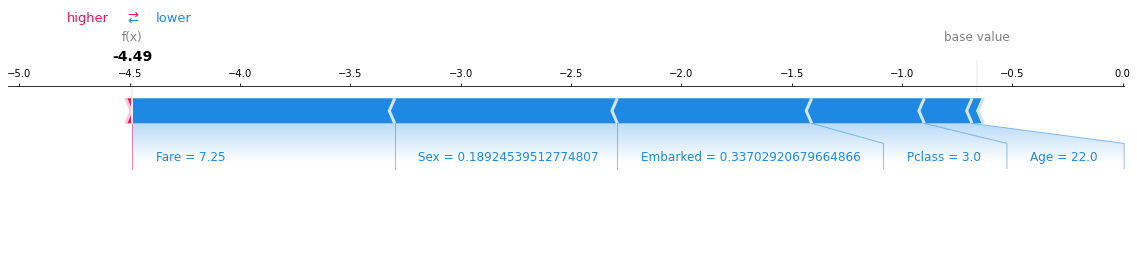

Test record number: 1
Actual value: 1
Predicted value: probability 0.9923; log odds 4.860
Sex       3.722653
Pclass    1.722925
Fare      0.771120
Name: 1, dtype: float32


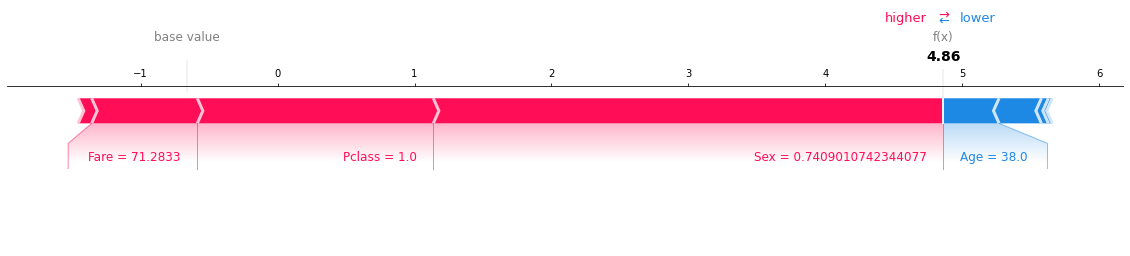

Test record number: 2
Actual value: 1
Predicted value: probability 0.2931; log odds -0.880
Sex         1.950301
Pclass     -1.506644
Embarked   -0.798577
Name: 2, dtype: float32


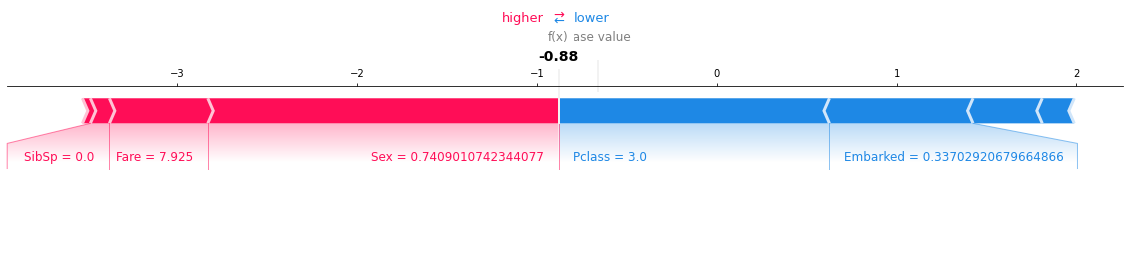

Test record number: 3
Actual value: 1
Predicted value: probability 0.9994; log odds 7.496
Sex       4.009109
Pclass    2.762744
Fare      0.916287
Name: 3, dtype: float32


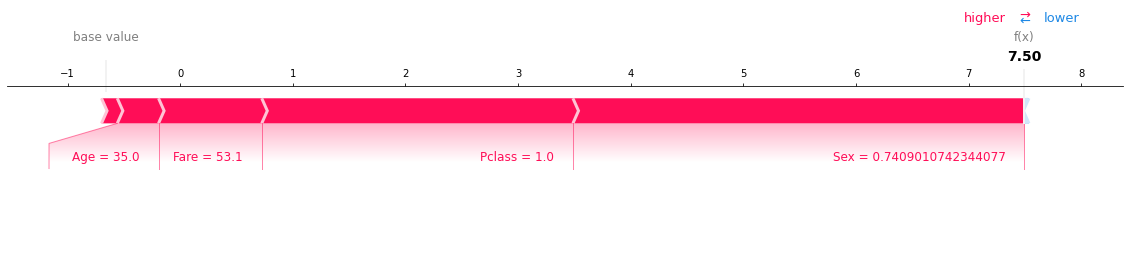

Test record number: 4
Actual value: 0
Predicted value: probability 0.0441; log odds -3.077
Pclass     -0.771217
Age        -0.632607
Embarked   -0.390379
Name: 4, dtype: float32


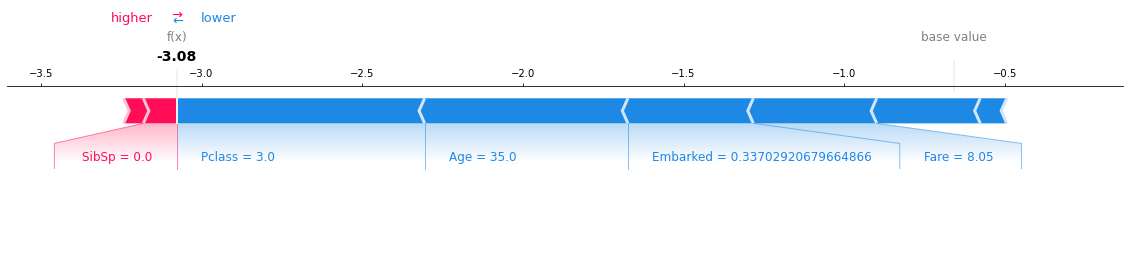

In [28]:
preds_proba = pipeline.predict_proba(titanic_df[predictors])[:, 1]

show_shap_ind(explainer, X_features, titanic_df[target], preds_proba, n_samples=5)

In [29]:
n_samples = 50
shap.force_plot(explainer.expected_value, shap_values[:n_samples], X_features[:n_samples])

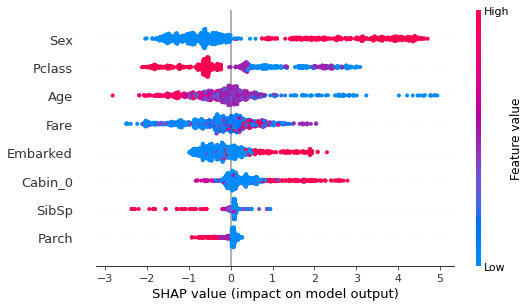

In [30]:
shap.summary_plot(shap_values, X_features)

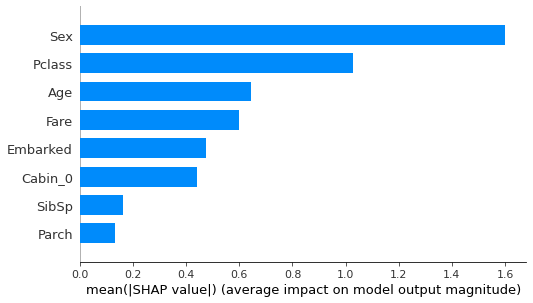

In [31]:
shap.summary_plot(shap_values, X_features, plot_type='bar')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


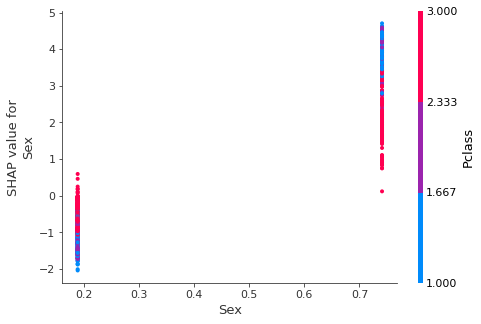

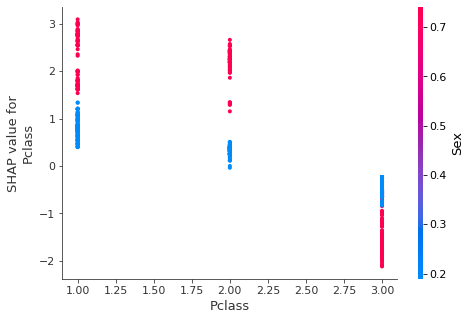

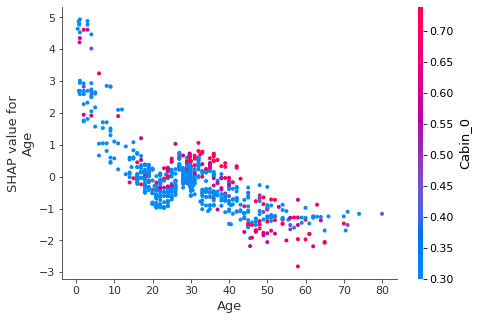

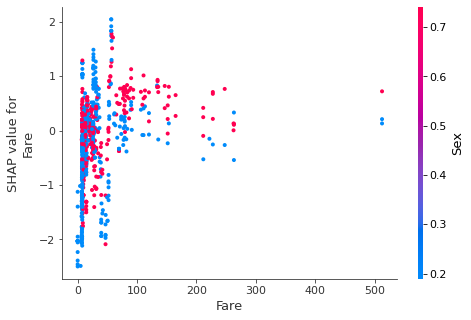

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


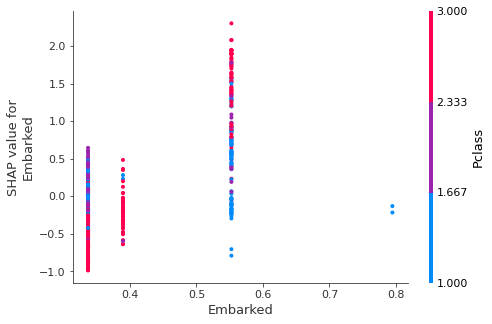

In [32]:
shap_values_total = pd.DataFrame(shap_values, columns=feature_names).abs().sum(axis=0)
rdr = shap_values_total.abs().sort_values(ascending=False)
shap_values_total = shap_values_total[rdr.index]
names = shap_values_total.index.values.tolist()[:5]

for name in names:
    shap.dependence_plot(name, shap_values, X_features)

In [33]:
n_samples = 5
X_new = X_features.iloc[:n_samples]
    
shap_values_ind = explainer.shap_values(X_new)
shap_df = pd.DataFrame(shap_values_ind, columns=X_new.columns)

shap_df.head()



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


,Sex,Cabin_0,Embarked,Pclass,Age,Parch,Fare,SibSp
0,-1.008705,-0.050530,-0.880756,-0.510474,-0.216482,0.028016,-1.190611,-0.000410
1,3.722653,-0.309112,-0.027810,1.722925,-0.407579,0.098099,0.771120,-0.050879
2,1.950301,-0.177920,-0.798577,-1.506644,-0.384981,0.044094,0.547282,0.105835
3,4.009109,-0.012579,-0.015198,2.762744,0.366159,0.140251,0.916287,-0.011486
4,-0.322119,-0.082688,-0.390379,-0.771217,-0.632607,0.061162,-0.383970,0.104470


In [34]:
explainer = shap.Explainer(pipeline['gbm'])
shap_values = explainer(X_features)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Test record number: 0
Actual value: 0
Predicted value: probability 0.0111; log odds -4.490
Fare       -1.190611
Sex        -1.008705
Embarked   -0.880756
Name: 0, dtype: float32


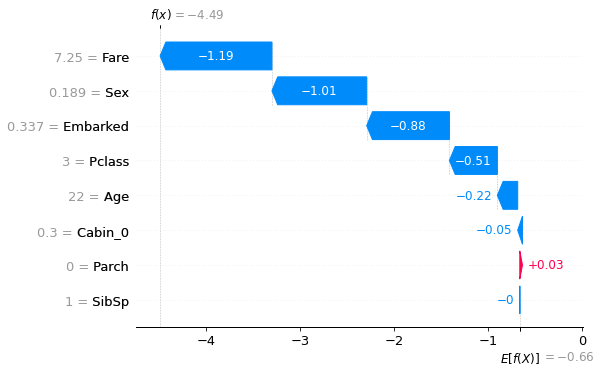

Test record number: 1
Actual value: 1
Predicted value: probability 0.9923; log odds 4.860
Sex       3.722653
Pclass    1.722925
Fare      0.771120
Name: 1, dtype: float32


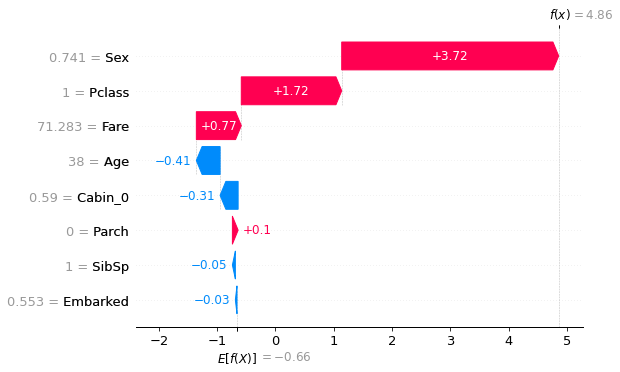

Test record number: 2
Actual value: 1
Predicted value: probability 0.2931; log odds -0.880
Sex         1.950301
Pclass     -1.506644
Embarked   -0.798577
Name: 2, dtype: float32


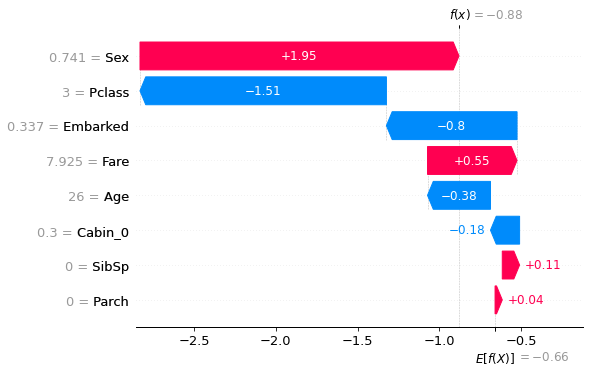

Test record number: 3
Actual value: 1
Predicted value: probability 0.9994; log odds 7.496
Sex       4.009109
Pclass    2.762744
Fare      0.916287
Name: 3, dtype: float32


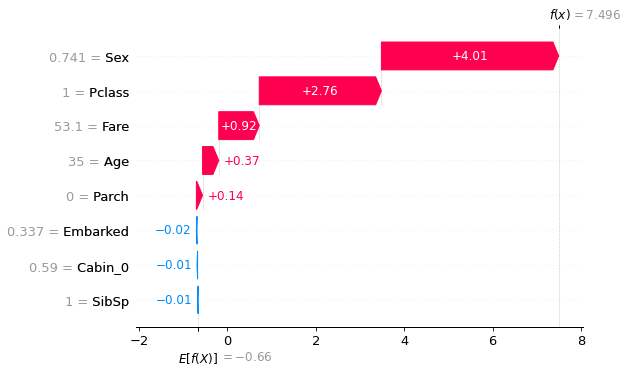

Test record number: 4
Actual value: 0
Predicted value: probability 0.0441; log odds -3.077
Pclass     -0.771217
Age        -0.632607
Embarked   -0.390379
Name: 4, dtype: float32


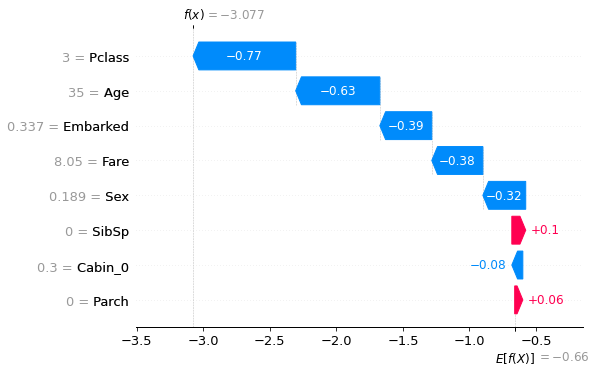

In [35]:
show_shap_ind(explainer, X_features, titanic_df[target], preds_proba, n_samples=5, shap_func='waterfall_plot')

## Best and worst examples

Now we have recalled how to build the SHAP water fall plots properly, we can examine the best and worst observation as we did with the true logistic regression.

In [36]:
preds_proba_srs = pd.Series(preds_proba)
preds_max = preds_proba_srs.argmax()
preds_min = preds_proba_srs.argmin()
preds_proba_srs.iloc[[preds_max, preds_min]]

759    0.999951
592    0.001822
dtype: float32

### Most likely to survive

In [37]:
titanic_df.iloc[preds_max]

PassengerId                                                  760
Survived                                                       1
Pclass                                                         1
Name           Rothes, the Countess. of (Lucy Noel Martha Dye...
Sex                                                       female
Age                                                           33
SibSp                                                          0
Parch                                                          0
Ticket                                                    110152
Fare                                                        86.5
Cabin                                                        B77
Embarked                                                       S
Cabin_0                                                        B
Name: 759, dtype: object

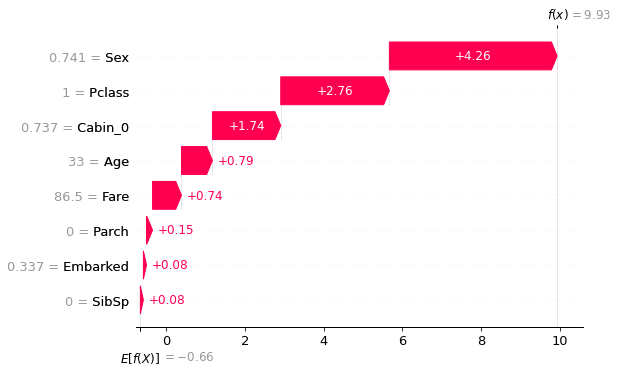

In [38]:
shap.plots.waterfall(shap_values[preds_max])

### Least likely to survive

In [39]:
titanic_df.iloc[preds_min]

PassengerId                           593
Survived                                0
Pclass                                  3
Name           Elsbury, Mr. William James
Sex                                  male
Age                                    47
SibSp                                   0
Parch                                   0
Ticket                           A/5 3902
Fare                                 7.25
Cabin                                 NaN
Embarked                                S
Cabin_0                               NaN
Name: 592, dtype: object

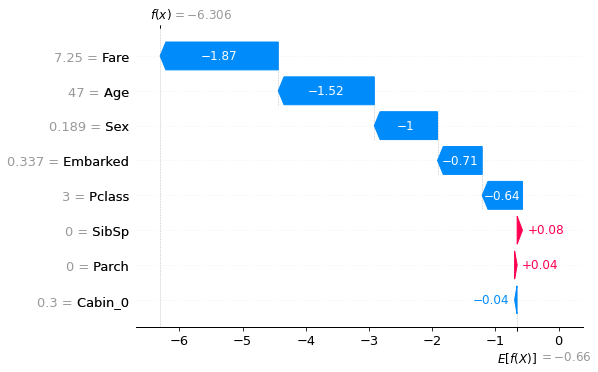

In [40]:
shap.plots.waterfall(shap_values[preds_min])

# Kaggle submission

As this is a Kaggle data set, we can

1. make predictions against the test set
2. submit the test set to Kaggle to see how well our model performs

In [51]:
test_filename = 'test.csv'
test_path = '~/repos/titanic/data'
test_df = pd.read_csv(os.path.join(test_path, test_filename))
test_df['Cabin_0'] = test_df['Cabin'].str.slice(stop=1)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_0
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN


In [52]:
test_proba = pipeline.predict(test_df[predictors])
test_df['Survived'] = pd.Series(test_proba.tolist())

In [55]:
test_df[['PassengerId', 'Survived']].to_csv(os.path.join(test_path, 'submission.csv'), index=False)